In [24]:
import tensorflow as tf

Epoch 1/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 2.1629 - val_loss: 0.7908
Epoch 2/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.6957 - val_loss: 0.7812
Epoch 3/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.6429 - val_loss: 0.7804
Epoch 4/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.5810 - val_loss: 0.7769
Epoch 5/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.5065 - val_loss: 0.7998
Epoch 6/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.4209 - val_loss: 0.8264
Epoch 7/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.3603 - val_loss: 0.8602
Epoch 8/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.3072 - val_loss: 0.8743
Epoch 9/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2700 - val_loss: 0.8917
Epoch 10/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2409 - val_loss: 0.9268
631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
RMSE: 0.9627
MAE: 0.7421


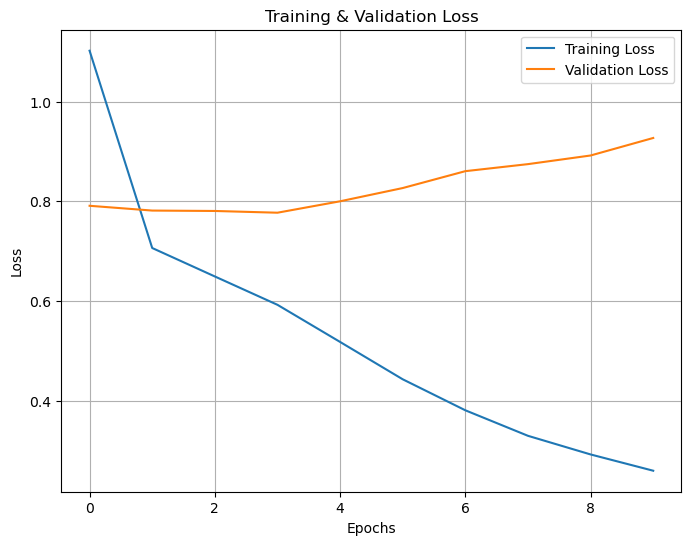

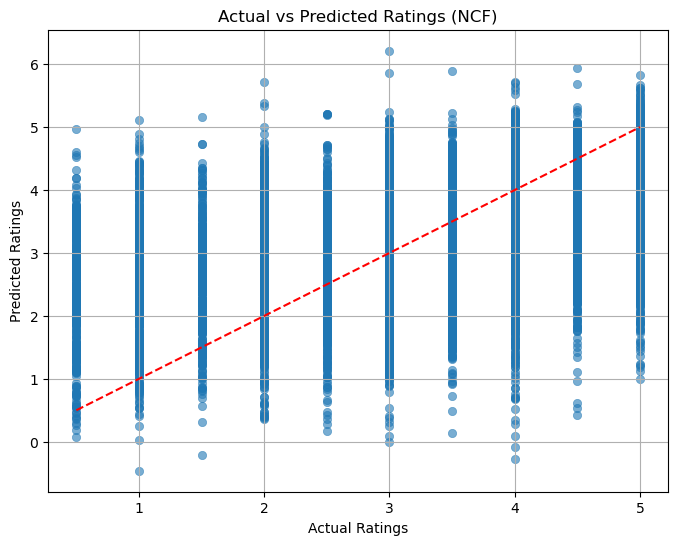

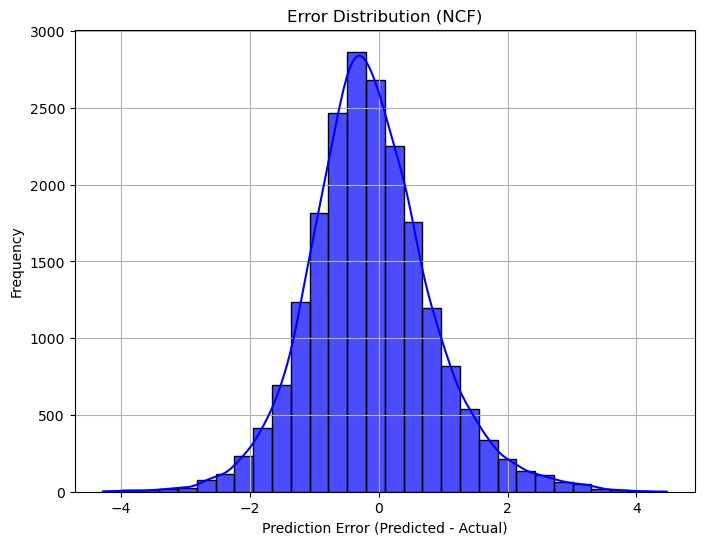

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data (example: rating data with userId, movieId, rating)
rating = pd.read_csv('data/ratings.csv')

# Step 1: Preprocess Data
# Ensure no missing values and proper user-item mapping
rating = rating.dropna(subset=['userId', 'movieId', 'rating'])

# Map userId and movieId to indices for neural network input
user_mapping = {uid: idx for idx, uid in enumerate(rating['userId'].unique())}
movie_mapping = {mid: idx for idx, mid in enumerate(rating['movieId'].unique())}

rating['userId'] = rating['userId'].map(user_mapping)
rating['movieId'] = rating['movieId'].map(movie_mapping)

# Prepare training and testing data
train_data, test_data = train_test_split(rating, test_size=0.2, random_state=42)

# Step 2: Neural Collaborative Filtering Model
class NCFModel(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_dim=50):
        super(NCFModel, self).__init__()
        # Embeddings for users and items
        self.user_embedding = layers.Embedding(num_users, embedding_dim)
        self.item_embedding = layers.Embedding(num_items, embedding_dim)
        
        # MLP layers for the neural network
        self.fc1 = layers.Dense(128, activation='relu')
        self.fc2 = layers.Dense(64, activation='relu')
        self.fc3 = layers.Dense(1, activation='linear')  # Output layer for rating prediction
        
    def call(self, inputs):
        user, item = inputs
        
        # Lookup user and item embeddings
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        
        # Concatenate user and item embeddings
        x = layers.concatenate([user_emb, item_emb])
        
        # Pass through MLP layers
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

# Step 3: Prepare Data for Training
train_user_input = np.array(train_data['userId'])
train_item_input = np.array(train_data['movieId'])
train_ratings = np.array(train_data['rating'], dtype=np.float32)

test_user_input = np.array(test_data['userId'])
test_item_input = np.array(test_data['movieId'])
test_ratings = np.array(test_data['rating'], dtype=np.float32)

# Step 4: Initialize Model
num_users = len(user_mapping)
num_items = len(movie_mapping)

model = NCFModel(num_users, num_items, embedding_dim=50)

# Step 5: Compile and Train the Model
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    [train_user_input, train_item_input],
    train_ratings,
    epochs=10,
    batch_size=64,
    validation_data=([test_user_input, test_item_input], test_ratings)
)

# Step 6: Evaluate the Model
predictions = model.predict([test_user_input, test_item_input])

# RMSE and MAE evaluation
rmse = np.sqrt(mean_squared_error(test_ratings, predictions))
mae = mean_absolute_error(test_ratings, predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Step 7: Visualizations

# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Actual vs Predicted Ratings
plt.figure(figsize=(8, 6))
sns.scatterplot(x=test_ratings, y=predictions.flatten(), alpha=0.6, edgecolor=None)
plt.plot([min(test_ratings), max(test_ratings)], [min(test_ratings), max(test_ratings)], color="red", linestyle="--")
plt.title("Actual vs Predicted Ratings (NCF)")
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.grid(True)
plt.show()

# Plot Error Distribution
errors = predictions.flatten() - test_ratings
plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=30, kde=True, color="blue", alpha=0.7)
plt.title("Error Distribution (NCF)")
plt.xlabel("Prediction Error (Predicted - Actual)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Average Precision: 0.7216
Average Recall: 0.6588


C:\Users\maske\AppData\Local\Temp\ipykernel_21744\297328930.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Precision", "Recall"], y=[avg_precision, avg_recall], palette="viridis")


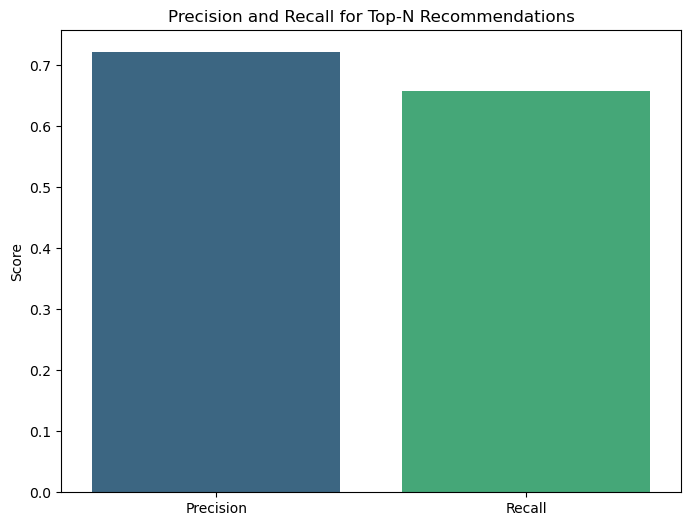

In [26]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

# Define a threshold to classify relevant items
relevant_threshold = 3.5  # Consider ratings above 3.5 as relevant

# Define top-N recommendation
N = 10  # Top-N recommendations

# Step 1: Generate predictions for all users and items
user_item_pairs = test_data[['userId', 'movieId']].drop_duplicates()  # All user-item pairs in the test set
predicted_ratings = model.predict([user_item_pairs['userId'].values, user_item_pairs['movieId'].values])

# Add predicted ratings to the test data
user_item_pairs['predicted_rating'] = predicted_ratings.flatten()

# Step 2: For each user, recommend top-N items
top_n_recommendations = {}

for user_id in user_item_pairs['userId'].unique():
    user_ratings = user_item_pairs[user_item_pairs['userId'] == user_id]
    # Sort by predicted rating and take top-N
    top_n_recommendations[user_id] = user_ratings.nlargest(N, 'predicted_rating')

# Step 3: Define relevant items (ratings > threshold)
relevant_items = test_data[test_data['rating'] >= relevant_threshold]

# Step 4: Compute Precision and Recall for each user
def calculate_precision_recall(user_id):
    # Get the top-N recommended items for this user
    recommended_items = top_n_recommendations.get(user_id, pd.DataFrame())
    
    # Get the relevant items for this user
    relevant_items_for_user = relevant_items[relevant_items['userId'] == user_id]
    
    # True Positives: Recommended and relevant items
    true_positives = recommended_items[recommended_items['movieId'].isin(relevant_items_for_user['movieId'])]
    
    # False Positives: Recommended but not relevant
    false_positives = recommended_items[~recommended_items['movieId'].isin(relevant_items_for_user['movieId'])]
    
    # False Negatives: Relevant but not recommended
    false_negatives = relevant_items_for_user[~relevant_items_for_user['movieId'].isin(recommended_items['movieId'])]
    
    # Precision and Recall
    precision = len(true_positives) / (len(true_positives) + len(false_positives)) if len(true_positives) + len(false_positives) > 0 else 0
    recall = len(true_positives) / (len(true_positives) + len(false_negatives)) if len(true_positives) + len(false_negatives) > 0 else 0
    
    return precision, recall

# Calculate Precision and Recall for all users
precision_list = []
recall_list = []

for user_id in user_item_pairs['userId'].unique():
    precision, recall = calculate_precision_recall(user_id)
    precision_list.append(precision)
    recall_list.append(recall)

# Average Precision and Recall
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")

# Step 5: Visualizing Precision and Recall

# Plot Precision and Recall
plt.figure(figsize=(8, 6))
sns.barplot(x=["Precision", "Recall"], y=[avg_precision, avg_recall], palette="viridis")
plt.title("Precision and Recall for Top-N Recommendations")
plt.ylabel("Score")
plt.show()



## Hybrid Model using NCF and CBF



In [28]:
pip install torch


Epoch 1/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.1322 - loss: 0.5946 - val_accuracy: 0.1313 - val_loss: 0.5817
Epoch 2/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.1278 - loss: 0.5762 - val_accuracy: 0.1306 - val_loss: 0.5798
Epoch 3/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.1299 - loss: 0.5687 - val_accuracy: 0.1303 - val_loss: 0.5804
Epoch 4/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.1317 - loss: 0.5627 - val_accuracy: 0.1297 - val_loss: 0.5803
Epoch 5/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.1299 - loss: 0.5597 - val_accuracy: 0.1295 - val_loss: 0.5823
Epoch 6/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.1332 - loss: 0.5538 - val_accuracy: 0.1287 - val_loss: 0.5838
Epoch 7/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.1328 - loss: 0.5467 - val_accuracy: 0.1286 - val_loss: 0.5864
Epoch 8/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.1287 - loss: 0.5

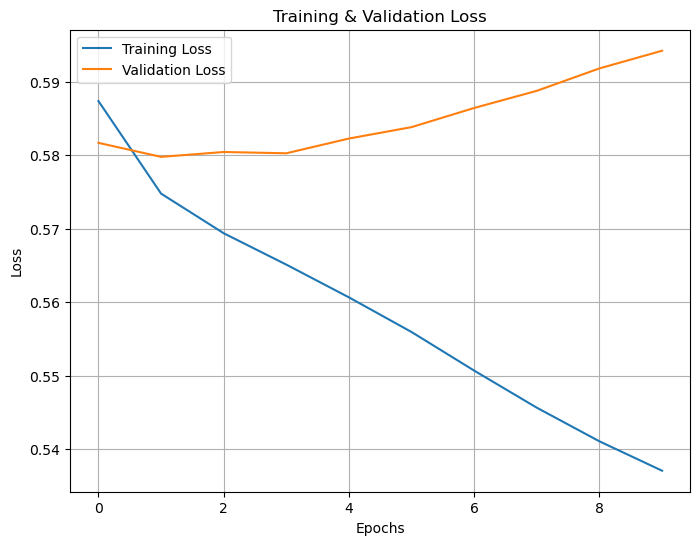

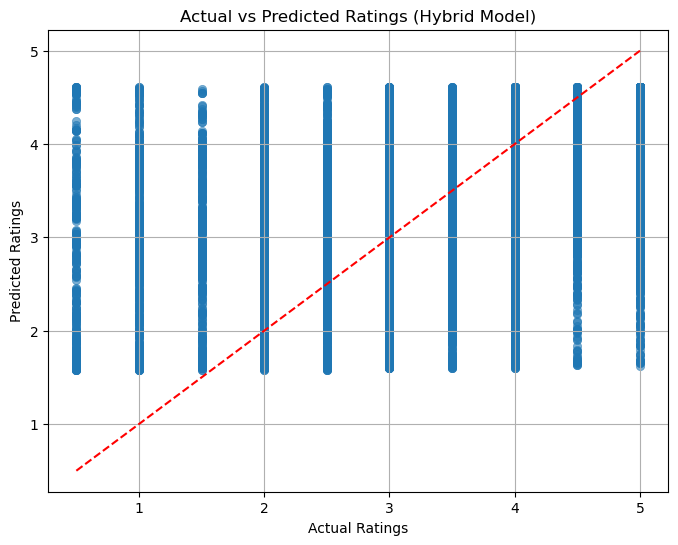

In [43]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the data
ratings = pd.read_csv('data/ratings.csv')
movies = pd.read_csv('data/movies.csv')

# Step 1: Preprocessing Ratings Data
ratings = ratings.dropna(subset=['userId', 'movieId', 'rating'])
user_mapping = {uid: idx for idx, uid in enumerate(ratings['userId'].unique())}
movie_mapping = {mid: idx for idx, mid in enumerate(ratings['movieId'].unique())}
ratings['userId'] = ratings['userId'].map(user_mapping)
ratings['movieId'] = ratings['movieId'].map(movie_mapping)

# Spliting into train and test
data_train, data_test = train_test_split(ratings, test_size=0.2, random_state=42)

# Step 2: Content-Based Filtering (CBF)
def preprocess_movie_data(movies):
    tfidf = TfidfVectorizer(stop_words='english')
    movies['genres'] = movies['genres'].fillna('')
    tfidf_matrix = tfidf.fit_transform(movies['genres'])
    return tfidf_matrix

tfidf_matrix = preprocess_movie_data(movies)
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Map movieId to indices for cosine similarity lookup
movie_idx_mapping = {mid: idx for idx, mid in enumerate(movies['movieId'])}

def get_cbf_predictions(user_id, movie_id):
    if movie_id not in movie_idx_mapping:
        return 0
    movie_idx = movie_idx_mapping[movie_id]
    similar_movies = cosine_sim[movie_idx]
    return similar_movies.mean()

# Step 3: Neural Collaborative Filtering (NCF) Class
class NCFModel(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_dim=50):
        super(NCFModel, self).__init__()
        self.user_embedding = layers.Embedding(num_users, embedding_dim)
        self.item_embedding = layers.Embedding(num_items, embedding_dim)
        self.fc1 = layers.Dense(128, activation='relu')
        self.fc2 = layers.Dense(64, activation='relu')
        self.fc3 = layers.Dense(1, activation='sigmoid')  # Output probability

    def call(self, inputs):
        user, item = inputs
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        x = layers.concatenate([user_emb, item_emb])
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Step 4: Hybrid Model
class HybridModel(tf.keras.Model):
    def __init__(self, ncf_model):
        super(HybridModel, self).__init__()
        self.ncf_model = ncf_model
        self.fc = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        user, item, cbf_scores = inputs
        ncf_output = self.ncf_model([user, item])
        x = layers.concatenate([ncf_output, cbf_scores], axis=1)
        x = self.fc(x)
        return x

# Preparing data for NCF
num_users = len(user_mapping)
num_items = len(movie_mapping)
train_user_input = np.array(data_train['userId'])
train_item_input = np.array(data_train['movieId'])
train_ratings = np.array(data_train['rating'] / 5.0, dtype=np.float32)  # Normalize ratings

test_user_input = np.array(data_test['userId'])
test_item_input = np.array(data_test['movieId'])
test_ratings = np.array(data_test['rating'] / 5.0, dtype=np.float32)  # Normalize ratings

# Add CBF scores
train_cbf_scores = np.array([get_cbf_predictions(u, m) for u, m in zip(data_train['userId'], data_train['movieId'])]).reshape(-1, 1)
test_cbf_scores = np.array([get_cbf_predictions(u, m) for u, m in zip(data_test['userId'], data_test['movieId'])]).reshape(-1, 1)

# Step 5: Initializing and Training Model
ncf_model = NCFModel(num_users, num_items)
hybrid_model = HybridModel(ncf_model)

hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = hybrid_model.fit(
    [train_user_input, train_item_input, train_cbf_scores],
    train_ratings,
    epochs=10,
    batch_size=64,
    validation_data=([test_user_input, test_item_input, test_cbf_scores], test_ratings)
)

# Step 6: Evaluating Model
predictions = hybrid_model.predict([test_user_input, test_item_input, test_cbf_scores])

# De-normalizing ratings
predicted_ratings = predictions.flatten() * 5

# Metrics
rmse = np.sqrt(mean_squared_error(data_test['rating'], predicted_ratings))
mae = mean_absolute_error(data_test['rating'], predicted_ratings)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Precision and Recall Calculation
threshold = 3.5  # Relevant if predicted rating >= 3.5
binary_actual = (data_test['rating'] >= threshold).astype(int)
binary_predicted = (predicted_ratings >= threshold).astype(int)

precision = precision_score(binary_actual, binary_predicted)
recall = recall_score(binary_actual, binary_predicted)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Step 7: Visualization
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_test['rating'], y=predicted_ratings, alpha=0.6, edgecolor=None)
plt.plot([min(data_test['rating']), max(data_test['rating'])], [min(data_test['rating']), max(data_test['rating'])], color="red", linestyle="--")
plt.title("Actual vs Predicted Ratings (Hybrid Model)")
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.grid(True)
plt.show()

## Hyper Prameter Tuning

In [ ]:
from itertools import product

# Defining hyperparameter grid
embedding_dims = [20, 50, 100]
dense_units = [64, 128, 256]
batch_sizes = [32, 64]
learning_rates = [0.001, 0.0005]
epochs = 5  # Using a smaller epoch count for tuning to save time

# Track results
results = []

for embed_dim, dense_unit, batch_size, lr in product(embedding_dims, dense_units, batch_sizes, learning_rates):
    print(f"Training with Embedding Dim: {embed_dim}, Dense Units: {dense_unit}, Batch Size: {batch_size}, LR: {lr}")
    
    # Initializing models with current hyperparameters
    ncf_model = NCFModel(num_users, num_items, embedding_dim=embed_dim)
    hybrid_model = HybridModel(ncf_model)

    # Compiling with current learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    hybrid_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Training the model
    history = hybrid_model.fit(
        [train_user_input, train_item_input, train_cbf_scores],
        train_ratings,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([test_user_input, test_item_input, test_cbf_scores], test_ratings),
        verbose=0  # Suppress verbose output for clarity
    )
    
    # Evaluating on the test set
    predictions = hybrid_model.predict([test_user_input, test_item_input, test_cbf_scores])
    predicted_ratings = predictions.flatten() * 5
    rmse = np.sqrt(mean_squared_error(data_test['rating'], predicted_ratings))
    mae = mean_absolute_error(data_test['rating'], predicted_ratings)
    
    # Storing results
    results.append({
        'embedding_dim': embed_dim,
        'dense_units': dense_unit,
        'batch_size': batch_size,
        'learning_rate': lr,
        'rmse': rmse,
        'mae': mae,
        'history': history.history
    })

# Finding the best configuration
best_config = min(results, key=lambda x: x['rmse'])
print(f"Best Configuration: {best_config}")

# Visualization of Loss and Metrics
for result in results:
    plt.figure(figsize=(8, 6))
    plt.plot(result['history']['loss'], label=f"Train Loss (Embedding={result['embedding_dim']}, Units={result['dense_units']})")
    plt.plot(result['history']['val_loss'], label=f"Val Loss (Embedding={result['embedding_dim']}, Units={result['dense_units']})")
    plt.title(f"Loss Curves (Batch Size={result['batch_size']}, LR={result['learning_rate']})")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Final Visualization: RMSE and MAE comparison
rmse_values = [res['rmse'] for res in results]
mae_values = [res['mae'] for res in results]
labels = [f"Embed={res['embedding_dim']}, Dense={res['dense_units']}, LR={res['learning_rate']}" for res in results]

plt.figure(figsize=(12, 6))
plt.barh(labels, rmse_values, color='skyblue', label='RMSE')
plt.barh(labels, mae_values, color='orange', alpha=0.7, label='MAE')
plt.title("RMSE and MAE for Different Hyperparameter Configurations")
plt.xlabel("Error")
plt.ylabel("Configurations")
plt.legend()
plt.grid(True)
plt.show()


Training with Embedding Dim: 20, Dense Units: 64, Batch Size: 32, LR: 0.001
631/631 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Training with Embedding Dim: 20, Dense Units: 64, Batch Size: 32, LR: 0.0005
631/631 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Training with Embedding Dim: 20, Dense Units: 64, Batch Size: 64, LR: 0.001
631/631 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Training with Embedding Dim: 20, Dense Units: 64, Batch Size: 64, LR: 0.0005
631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Training with Embedding Dim: 20, Dense Units: 128, Batch Size: 32, LR: 0.001
631/631 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Training with Embedding Dim: 20, Dense Units: 128, Batch Size: 32, LR: 0.0005
631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Training with Embedding Dim: 20, Dense Units: 128, Batch Size: 64, LR: 0.001
631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Training with Embedding Dim: 20, Dense Units: 128, Batch Size: 64, LR: 0.0005
631/631 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Training with Embedding Dim: 20, Dense Units: 256, Batch